In [1]:
import xarray as xr
import xesmf as xe
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

### Import local modules

In [2]:
import os
import sys
module_path_lupft = '/home/glemieux/Repos/NGEET/fates/tools/landuse/src/landusepft/'
sys.path.append(module_path_lupft)
from landusepftmod import ImportLandusePFTFile, ImportStaticLUH2File
from landusepftmod import RenormalizePFTs, AddLatLonCoordinates, DefineMask
module_path_luh2 = '/home/glemieux/Repos/NGEET/fates/tools/luh2/'
sys.path.append(module_path_luh2)
from luh2mod import SetMaskSurfData, SetMaskLUH2, ImportData, BoundsVariableFixLUH2

### Define helper plot function

In [3]:
def plotnatpft(variable, colormap='magma_r'):
    fg = variable.plot(x='lon',y='lat',col='natpft', col_wrap=4, cmap=colormap, 
                   transform=ccrs.PlateCarree(), subplot_kws=dict(projection=ccrs.Robinson()), add_colorbar=False)

    for ax in fg.axes.flat:
        ax.coastlines() 

    # color bar
    fg.add_colorbar(orientation="vertical", shrink=0.6, anchor=(1.5, 0.5))
    plt.subplots_adjust(hspace=-0.65)

### Import data

In [6]:
luh2_static_file = '/home/glemieux/Data/luh2/staticData_quarterdeg.nc'
regrid_target_file = '/home/glemieux/Data/surfdat/surfdata_4x5_16pfts_Irrig_CMIP6_simyr2000_c170824.nc'
clm_surface_file = '/home/glemieux/Data/luh2/lu-pft/CLM5_current_surf_deg025.nc'
clm_luhforest_file = '/home/glemieux/Data/luh2/lu-pft/CLM5_current_luhforest_deg025.nc'
clm_luhpasture_file = '/home/glemieux/Data/luh2/lu-pft/CLM5_current_luhpasture_deg025.nc'
clm_luhother_file = '/home/glemieux/Data/luh2/lu-pft/CLM5_current_luhother_deg025.nc'
statefile = '/home/glemieux/Data/luh2/states.nc'
filelist = [clm_surface_file, clm_luhforest_file, clm_luhpasture_file, clm_luhother_file]

In [7]:
ds_static  = ImportStaticLUH2File(luh2_static_file)

In [8]:
ds_target = ImportData(regrid_target_file)

Input file dataset opened: /home/glemieux/Data/surfdat/surfdata_4x5_16pfts_Irrig_CMIP6_simyr2000_c170824.nc
PrepDataset: SurfData
Surface dataset dimensions renamed for xESMF
data set updated for xESMF



In [9]:
filelist = [clm_surface_file,
            clm_luhforest_file,
            clm_luhpasture_file,
            clm_luhother_file]
ds_landusepfts = []
for filename in filelist:
    ds_landusepfts.append(ImportLandusePFTFile(filename))

## Prep Data

In [10]:
mask_static = DefineMask(ds_static)

In [11]:
for dataset in ds_landusepfts:
    AddLatLonCoordinates(dataset)

In [12]:
SetMaskSurfData(ds_target)

<xarray.Dataset>
Dimensions:                  (lat: 46, lon: 72, nlevsoi: 10, natpft: 15,
                              cft: 2, time: 12, lsmpft: 17, numurbl: 3,
                              numrad: 2, nlevurb: 5, nglcecp1: 11, nglcec: 10)
Coordinates:
  * natpft                   (natpft) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14
  * cft                      (cft) int32 15 16
  * time                     (time) int32 1 2 3 4 5 6 7 8 9 10 11 12
  * lon                      (lon) float64 0.0 5.0 10.0 ... 345.0 350.0 355.0
  * lat                      (lat) float64 -90.0 -86.0 -82.0 ... 82.0 86.0 90.0
Dimensions without coordinates: nlevsoi, lsmpft, numurbl, numrad, nlevurb,
                                nglcecp1, nglcec
Data variables: (12/89)
    mxsoil_color             int32 ...
    SOIL_COLOR               (lat, lon) int32 ...
    PCT_SAND                 (nlevsoi, lat, lon) float64 ...
    PCT_CLAY                 (nlevsoi, lat, lon) float64 ...
    ORGANIC                  (nlevsoi, lat, lon) float64 ...
    FMAX                     (lat, lon) float64 ...
    ...                       ...
    CONST_HARVEST_SH3        (lat, lon) float64 ...
    CONST_GRAZING            (lat, lon) float64 ...
    CONST_FERTNITRO_CFT      (cft, lat, lon) float64 ...
    UNREPRESENTED_PFT_LULCC  (natpft, lat, lon) float64 ...
    UNREPRESENTED_CFT_LULCC  (cft, lat, lon) float64 ...
    mask                     (lat, lon) bool False False False ... False False
Attributes: (12/53)
    Conventions:                          NCAR-CSM
    History_Log:                          created on: 08-24-17 14:43:08
    Logname:                              erik
    Host:                                 cheyenne1
    Source:                               Community Land Model: CLM4
    Version:                              $HeadURL: https://svn-ccsm-models.c...
    ...                                   ...
    map_ch4_params_file:                  map_360x720_cruncep_to_4x5_nomask_a...
    Soil_texture_raw_data_file_name:      mksrf_soitex.10level.c010119.nc
    Soil_color_raw_data_file_name:        mksrf_soilcolor_CMIP6_simyr2005.c17...
    Fmax_raw_data_file_name:              mksrf_fmax_3x3min_USGS_c120911.nc
    Organic_matter_raw_data_file_name:    mksrf_organic_10level_5x5min_ISRIC-...
    Vegetation_type_raw_data_filename:    mksrf_landuse_histclm50_LUH2_2000.c...

## Calculate landuse pft fractions

In [13]:
percent = []
percent_bareground = ds_landusepfts[0].PCT_NAT_PFT.isel(natpft=0)
percent_bareground = (percent_bareground / 100.0) * mask_static
percent.append(percent_bareground)

In [14]:
for data_array in ds_landusepfts:
    percent.append(RenormalizePFTs(data_array))

In [15]:
percent[2] = ds_static.fstnf * percent[2] + (1. - ds_static.fstnf) * percent[-1]

In [16]:
ds_var_names = ['frac_brgnd','frac_csurf','frac_primr','frac_pastr','frac_range']

In [17]:
ds_percent = xr.Dataset()
for index,data_array in enumerate(percent):
    ds_percent = ds_percent.merge(data_array.to_dataset(name=ds_var_names[index]))

In [18]:
ds_percent = ds_percent.merge(percent[2].to_dataset(name='frac_secnd'))

/tmp/ipykernel_297400/941046407.py:5: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax in fg.axes.flat:


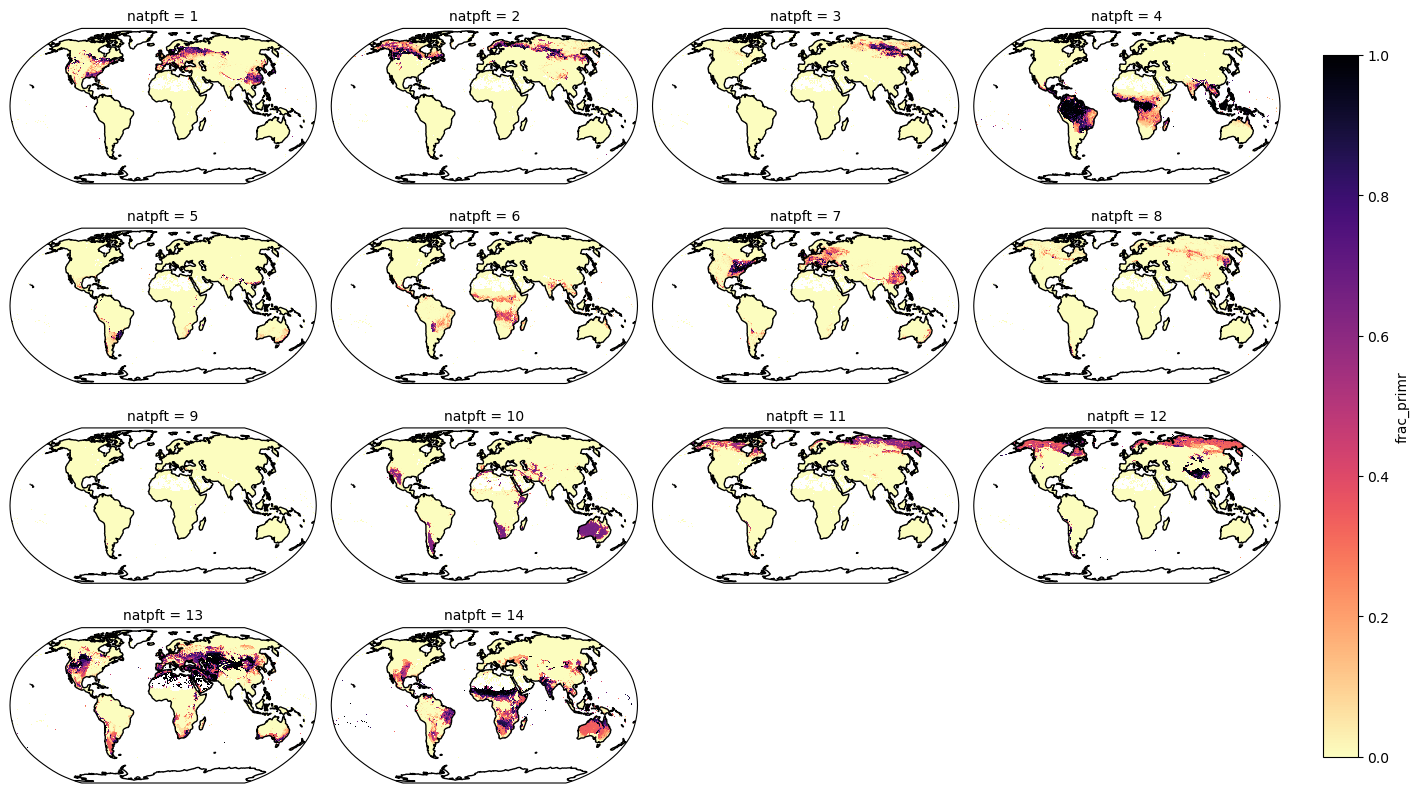

In [24]:
plotnatpft(ds_percent.frac_primr)

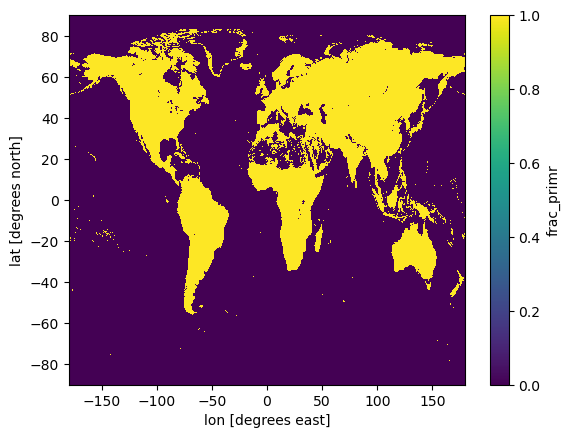

In [29]:
ds_percent.frac_primr.sum(dim='natpft').plot()

## Regrid data

In [25]:
regridder = xe.Regridder(ds_percent, ds_target, "conservative_normed")
ds_regrid = regridder(ds_percent)

/home/glemieux/local/conda/miniconda3/envs/jupyter-luh2/lib/python3.10/site-packages/xesmf/backend.py:56: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')
/home/glemieux/local/conda/miniconda3/envs/jupyter-luh2/lib/python3.10/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


/tmp/ipykernel_297400/941046407.py:5: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax in fg.axes.flat:


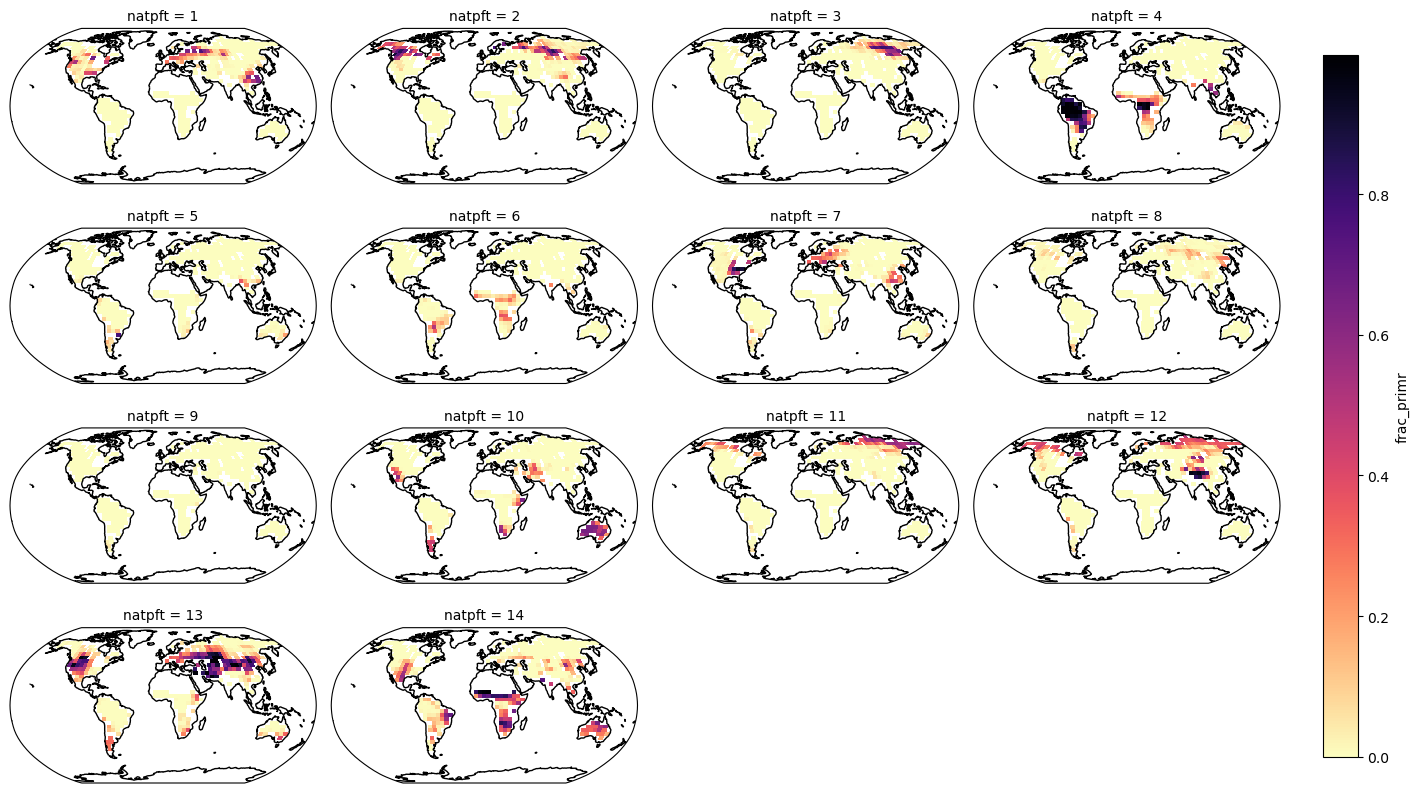

In [26]:
plotnatpft(ds_regrid.frac_primr)

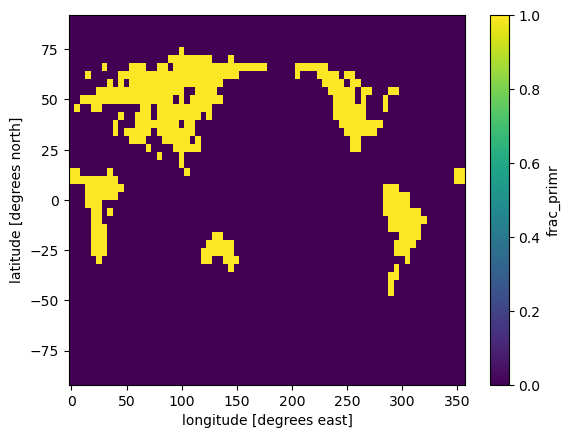

In [27]:
ds_regrid.frac_primr.sum(dim='natpft').plot()